In [ ]:
from google.colab import drive,files
drive.mount('/content/drive')
%cd drive/MyDrive/work/S2/NLP/medal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/work/S2/NLP/medal'
/content/drive/MyDrive/work/S2/NLP/medal


In [ ]:
%pip install transformers fasttext -q

## Testing pruning

In [ ]:
import torch

from downstream.electra import Electra
from downstream.utils import load_model


DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

output_size = 1

net = Electra(
    output_size=output_size,
    device=DEVICE,
)

net = load_model(net, './models/electra_medal_mortality_3.pt', DEVICE)

#net.electra.prune_heads({1: [0, 2], 2: [2, 3]})

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pretrained: odict_keys(['cls_query', 'electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.intermediate.dense.weight', 'electra.encoder.layer.0.inter

In [ ]:
import os
import time
import sys

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality, load_mimic_diagnosis, load_model, predict, evaluate, train_loop
from downstream.electra import Electra
import pandas as pd
import numpy as np

from downstream.tokenizer_and_dataset import FastTextTokenizer, MimicDataset, HuggingfaceDataset

from torch.utils.tensorboard import SummaryWriter


EXPERIMENT_DIR = ARGS.get('savedir')
N_EPOCHS = ARGS.get('epochs')
BATCH_SIZE = ARGS.get('batchsize')
N_CPU_CORES = ARGS.get('ncpu')
MODEL_TYPE = ARGS.get('model')
TASK = ARGS.get('task')
TEST = ARGS.get('test')
USE_PRETRAIN = True if ARGS.get('pretrained_model') else False

if TEST and not USE_PRETRAIN:
    raise Exception("no model preovided for testing")

if not USE_PRETRAIN:
    print("No pretrained model provided. Will train from scratch.")

# Prelim
torch.set_num_threads(N_CPU_CORES)
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Load data
if TASK in ['mimic-mortality']:
    train, valid, test = load_mimic_mortality(ARGS.get('data_dir'), ARGS.get('data_filename'))
elif TASK in ['mimic-diagnosis']:
    train, valid, test, diag_to_idx = \
        load_mimic_diagnosis(ARGS.get('data_dir'), ARGS.get('data_filename'), ARGS.get('diag_to_idx_path'))
print("Data loaded")

# Create tokenizer objects
if MODEL_TYPE == "electra":
    tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
else:
    # Create word index and load Fasttext embedding matrix
    tokenizer = FastTextTokenizer(verbose=True)
    tokenizer.build_word_index(train.TEXT, valid.TEXT, test.TEXT)
    tokenizer.build_embedding_matrix(ARGS.get('embs_path'))

if TASK in ['mimic-mortality']:
    output_size = 1
    label_col = 'LABEL_NUM'
elif TASK in ['mimic-diagnosis']:
    output_size = len(diag_to_idx)
    label_col = 'DIAG'

# Create torch Dataset objects
if MODEL_TYPE in ["rnnsoft", "rnn"]:
    if TEST:
        test_data = MimicDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
    else:
        train_data = MimicDataset(train, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
        valid_data = MimicDataset(valid, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
else:
    if TEST:
        test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
    else:
        train_data = HuggingfaceDataset(train, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
        valid_data = HuggingfaceDataset(valid, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
print("Dataset created")

# Define network, loss function and optimizer


net = Electra(
    output_size=output_size,
    device=DEVICE,
)

net = load_model(net, ARGS.get('pretrained_model'), DEVICE)

print('model: {}'.format(net))
if TASK in ['mimic-mortality', 'mimic-diagnosis']:
    criterion = nn.BCELoss()
if not TEST:
    optimizer = optim.Adam(net.parameters(), ARGS.get('lr'))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=8) \
        if ARGS.get('use_scheduler') else None

# Create save directory
time_stamp = time.strftime("%m-%d-%H-%M", time.localtime())
save_dir = os.path.join(EXPERIMENT_DIR, time_stamp)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save configs
model_desc_output = [": ".join([str(k), str(v)]) for k, v in ARGS.items()]
with open(os.path.join(save_dir, 'configs.txt'), 'w') as file:
    file.writelines("\n".join(model_desc_output))

if not TEST:
    writer = SummaryWriter(f"runs/{TASK}/{MODEL_TYPE}-{time_stamp}")
    # Train network
    net, logs = train_loop(
        net, optimizer, criterion, train_data, valid_data, save_dir=save_dir, task=TASK, n_epochs=N_EPOCHS, \
            batch_size=BATCH_SIZE, verbose=True, scheduler=scheduler, save_every=ARGS.get('save_every'), \
            eval_every=ARGS.get('eval_every'), writer=writer,
    )
else:
    # Test
    logs = {k: [] for k in ['test_loss', 'test_metric']}
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'] = []
        logs['test_top_30_recall'] = []
    test_loader = DataLoader(
        range(len(test)), 
        shuffle=False, 
        batch_size=BATCH_SIZE
    )
    if TASK == 'mimic-mortality':
        test_preds = predict(net, test_loader, test_data, verbose=True).cpu().numpy()
        np.save(os.path.join(save_dir, 'test_preds.npy'), test_preds)
        test_loss, test_metric = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
    elif TASK == 'mimic-diagnosis':
        test_loss, test_metrics = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
        test_metric = test_metrics['top_10_recall']
    print(f"Test Loss: {test_loss:.4f} \tTest Metric:{test_metric:.4f}")
    if TASK == 'mimic-diagnosis':
        print(f"Test Top 5 Recall: {test_metrics['top_5_recall']:.4f} \tTest Top 30 Recall:{test_metrics['top_30_recall']:.4f}")
    print("="*50)
    logs['test_loss'].append(test_loss)
    logs['test_metric'].append(test_metric)
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'].append(test_metrics['top_5_recall'])
        logs['test_top_30_recall'].append(test_metrics['top_30_recall'])

# Save Model
if not TEST:
    torch.save(net.state_dict(), os.path.join(save_dir, 'model.pt'))

# Save Logs
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(save_dir, 'logs.csv'))

## Imports

In [ ]:
# !python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.6 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=c25019c720a9b0fa9c6a41229b36aae96b94a904c560cf755e0ed5d42dabba1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ppn4ehp/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import csv
import glob
import json
import itertools
import random
import requests
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import spacy
#import textacy
import torch
from matplotlib.gridspec import GridSpec
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import framenet as fn
from spacy.symbols import nsubj, VERB
from tqdm import tqdm

#from pytorch_pretrained_bert import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import ElectraTokenizer
#nlp = spacy.load("en_core_web_md")
%matplotlib inline
plt.style.use('seaborn')

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Functions

In [ ]:
import torch

from downstream.electra import Electra
from downstream.utils import load_model

In [ ]:
import matplotlib.pyplot as plt

def visualize_all(attn, crop_len, n_layers=12, n_heads=4, title=""):
    """
    Full grid of attention maps [12x12]
    """
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(10, 24), sharex=True, sharey=True)
    
    for i in range(n_layers):
        for j in range(n_heads):
            im = axes[i, j].imshow(attn[i, j, :crop_len, :crop_len], cmap='Oranges')
            axes[i, j].axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)

    return fig

In [ ]:
def visualize_single(att_map, sentence_1, sentence_2, max_len, n_layers=12, n_heads=4):
    """
    Attention map for a given layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2
    
    plt.figure(figsize=(16, 12))
    plt.imshow(att_map[n_layer, n_head, :crop_len, :crop_len], cmap='Reds')
    plt.xticks(range(crop_len), bert_tokens, rotation=60, fontsize=12)
    plt.yticks(range(crop_len), bert_tokens, fontsize=12)

    plt.grid(False)

In [ ]:
# custom functiosn 

def get_model(path=None,output_size = 1):
    """
    Model loading.
    """
    net = Electra(output_size=output_size,device=DEVICE)

    # Loading weights
    #model.load_state_dict(torch.load(model_path))
    if path:
      print(f"loading model {path.split('/')[-1]}")
      net = load_model(net, path, DEVICE)

    net.eval()
    
    return net

In [ ]:
def visualize_before_and_after(before, after, title='', cmap="Greens"):
    """
    Visualize the difference between base BERT and fine-tuned BERT
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    ax1, ax2 = axes[0], axes[1]

    vmax = max(np.max(before), np.max(after))

    im = ax1.imshow(before, cmap=cmap, vmax=vmax)
    ax1.set_title('Base model')
    ax1.grid(False)

    im = ax2.imshow(after, cmap=cmap, vmax=vmax)
    ax2.set_title('Fine-tuned model')
    ax2.grid(False)

    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [ ]:
# See spacy docs for tag-pos relation
def detect_all_pos(sentence, pos='PRON'):
    """
    Detect all tokens with a given POS tag
    """
    if pos not in ['PRON', 'VERB', 'NOUN']:
        raise ValueError("POS not recognized")
        
    pos2tag = {'PRON': ['PRP', 'PRP$'],
               'NOUN': ['NN', 'NNP', 'NNPS', 'NNS'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']}
    
    doc = nlp(sentence, disable=['ner', 'parser'])
    targets = []
    for token in doc:
        if token.tag_ in pos2tag[pos]:
            targets.append(token.text)
    return set(targets)

In [ ]:
def detect_all_negations(sentence):
    """
    Check if there is a negation phrase in a sentence out of a list of manually curated negations
    """
    negation_words = ['neither', 'nor', 'not', 'never', 'none', "don't", "won't", "didn't", 
                     "hadn't", "haven't", "can't", "isn't", "wasn't", "shouldn't", "couldn't", "nothing", "nowhere"]
    
    targets = [word for word in negation_words if word in sentence]
    return set(targets)

In [ ]:
def detect_all_dep(sentence, label):
    """
    Get subject-object dependencies
    """
    doc = nlp(sentence, disable=['ner', 'pos'])
    
    label2dep = {'SUBJ': ['nsubj', "nsubjpass", "csubj", "csubjpass", "agent", "expl"], 
                 "OBJ": ['dobj', 'iobj', "dative", "attr", "oprd"]}
    
    targets = []
    for token in doc:
        if token.dep_ in label2dep[label]:
            targets.append(token.text)
    return set(targets)

In [ ]:
def get_max_target_weight(attn, target_indices):
    """
    Get the maximum attn weight out of target tokens (given by their indices)
    """
    if not target_indices:
        return 0
    avg_attn = np.mean(attn, axis=0)
    target_weights = avg_attn[target_indices]
    max_target_weight = np.max(target_weights)
    return max_target_weight

In [ ]:
def analyze_target_attention(sentence_1, sentence_2, max_len, model, feature='NOUN', n_layers=12, n_heads=12):
    """
    Analyze the attention weights for the target sentence and for a given syntactic feature
    """
    weights = np.zeros((n_layers, n_heads))
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else:
        crop_len = len(tokens_1) + 2

    if feature in ["NOUN", "PRON", "VERB"]:
        target_feat_1 = detect_all_pos(sentence_1, feature)
        target_feat_2 = detect_all_pos(sentence_2, feature)
    elif feature == "NEG":
        target_feat_1 = detect_all_negations(sentence_1)
        target_feat_2 = detect_all_negations(sentence_2)
    elif feature in ["SUBJ", "OBJ"]:
        target_feat_1 = detect_all_dep(sentence_1, feature)
        target_feat_2 = detect_all_dep(sentence_2, feature)
        
    bert_tokens_feat = list(itertools.chain.from_iterable([tokenizer.tokenize(feat) for feat in target_feat_1.union(target_feat_2)]))
    feat_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_feat]

    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_target_weight(output[l, h, :crop_len, :crop_len], feat_indices)
    
    return weights
            

In [ ]:
def extract_subj_verb(sentence):
    """
    Get subject-verb dependencies
    """
    doc = nlp(sentence)
    
    subj_verb = [] 
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            subj_verb.append((possible_subject.text, possible_subject.head.text))
    return subj_verb

In [ ]:
def get_max_source_target_weight(attn, source_indices, target_indices):
    """
    Calculate the maximum source-target attention weight out of all possible source-target pairs (given by their indices) 
    """
    if not source_indices or not target_indices:
        return 0
    
    weights = np.array([attn[source, target] for source, target in zip(source_indices, target_indices)])
    
    return np.max(weights)
    

In [ ]:
def analyze_cross_attention(sentence_1, sentence_2, max_len, model, relation, n_layers=12, n_heads=12):
    """
    Get maximum source-target attention weights for every layer and head
    """
    bert_tokens, tokens_1, tokens_2 = convert_to_bert_tokens(sentence_1, sentence_2, max_len)
    if tokens_2:
        crop_len = len(tokens_1) + len(tokens_2) + 3
    else: 
        crop_len = len(tokens_1) + 2
    
    if relation == "SUBJ-VERB" or "VERB-SUBJ":
        feats_1 = extract_subj_verb(sentence_1)
        feats_2 = extract_subj_verb(sentence_2)
    
    
    all_feats = feats_1 + feats_2
    source_tokens = [pair[0] for pair in all_feats]
    target_tokens = [pair[1] for pair in all_feats]
    
    if relation == "VERB-SUBJ":
        source_tokens, target_tokens = target_tokens, source_tokens
    
    bert_tokens_source = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in source_tokens]))
    bert_tokens_target = list(itertools.chain.from_iterable([tokenizer.tokenize(token) for token in target_tokens]))
    
    source_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_source]
    target_indices = [i for i, token in enumerate(bert_tokens) if token in bert_tokens_target]
    
    input_ids, input_mask, segment_ids = convert_to_bert_inputs(sentence_1, sentence_2, max_len)
    _, output = model(input_ids.unsqueeze(0), segment_ids.unsqueeze(0), input_mask.unsqueeze(0))

    output = output.squeeze(0).detach().numpy()

    weights = np.zeros((n_layers, n_heads))
    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_source_target_weight(output[l, h, :crop_len, :crop_len], source_indices, target_indices)
    
    return weights

## Setting parameters

In [ ]:
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

output_size = 1
max_len = 200
path_to_data ="./data/downstream"
n_layers = 12
n_heads = 4
path_to_model = './models/electra_medal_mortality_3.pt'


--------------------------

### 1. Load the dataset and fine_tuned model

In [ ]:
#Pretrained only

from transformers import AutoModel, ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

base_model = AutoModel.from_pretrained("google/electra-small-discriminator")
finetuned_model = AutoModel.from_pretrained("xhlu/electra-medal")

print("Models loaded")

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Models loaded


In [ ]:
# Like olga

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality
import random

# Load data

_, _, test = load_mimic_mortality("./data/downstream", "mimic.csv")

# Create tokenizer objects

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Get data to list of tuples

data = test[['LABEL_NUM','TEXT']]
#data = [(x[0],x[1],"") for x in subset.to_numpy()]

# for big datasets
# if len(data) > 1000:    
#     data = random.sample(data, 1000)
if len(data) > 1000: 
    data = data.sample(n=1000, random_state=32).to_numpy()

### 2. 12x12 attention map for a random example

In [ ]:
task = 'medical abbreviation disambiguation'

In [ ]:
example = data[4]
input = tokenizer(example[1], return_tensors='pt')
input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']
input_ids.shape
print(example[1])

respiratory care :  pt remains intubated and on vent .  peep increased to 10 for hypoxia .  suctioned small amts whitish secretions .  no rsbi done due to  ^ peep level .  morning abg -  -  7 . 43 / 43 / 109 / 29 . 



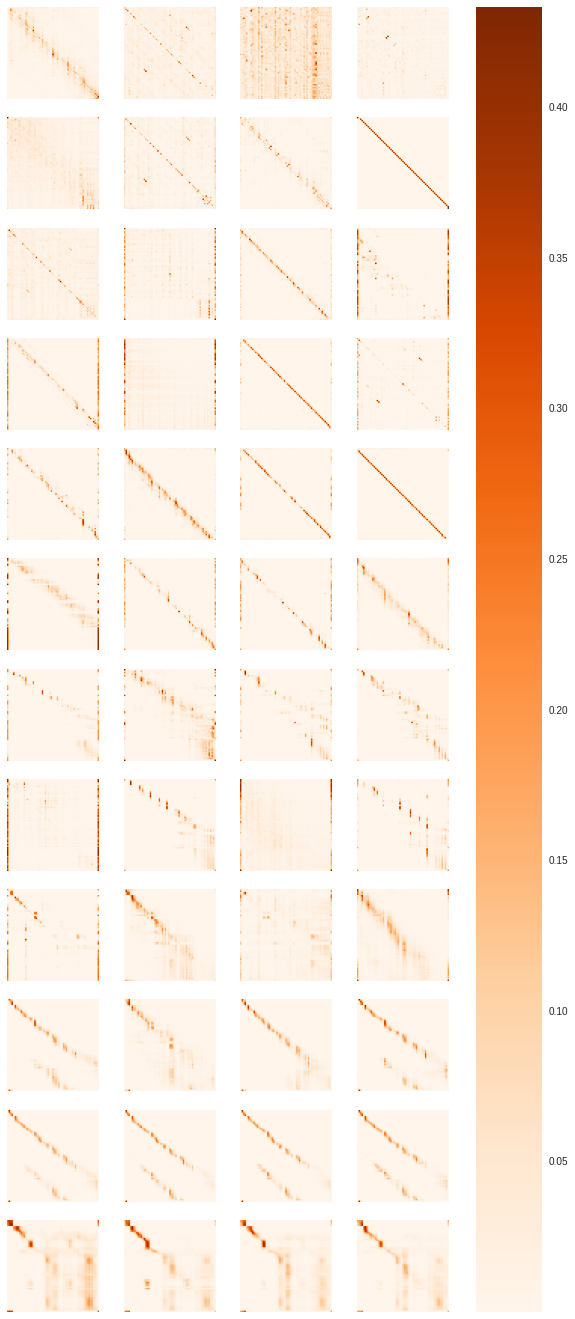

In [ ]:
example = data[4]
input = tokenizer(example[1], return_tensors='pt')
input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']

base_output = base_model(input_ids, input_mask, token_type_ids, output_attentions=True)
finetuned_output = finetuned_model(input_ids, input_mask, token_type_ids, output_attentions=True)

base_attentions = torch.stack(base_output.attentions, dim=1)
finetuned_attentions = torch.stack(finetuned_output.attentions, dim=1)

rand_output_base = base_attentions.squeeze(0).detach().numpy()
rand_output_finetuned  = finetuned_attentions.squeeze(0).detach().numpy()

crop_len = torch.sum(input_mask != 0)
fig = visualize_all(rand_output_finetuned, crop_len)#, title="Attention map for {}: medal-trained model".format(task))

In [ ]:
fig.savefig('medal_token_attention.png')
files.download('medal_token_attention.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

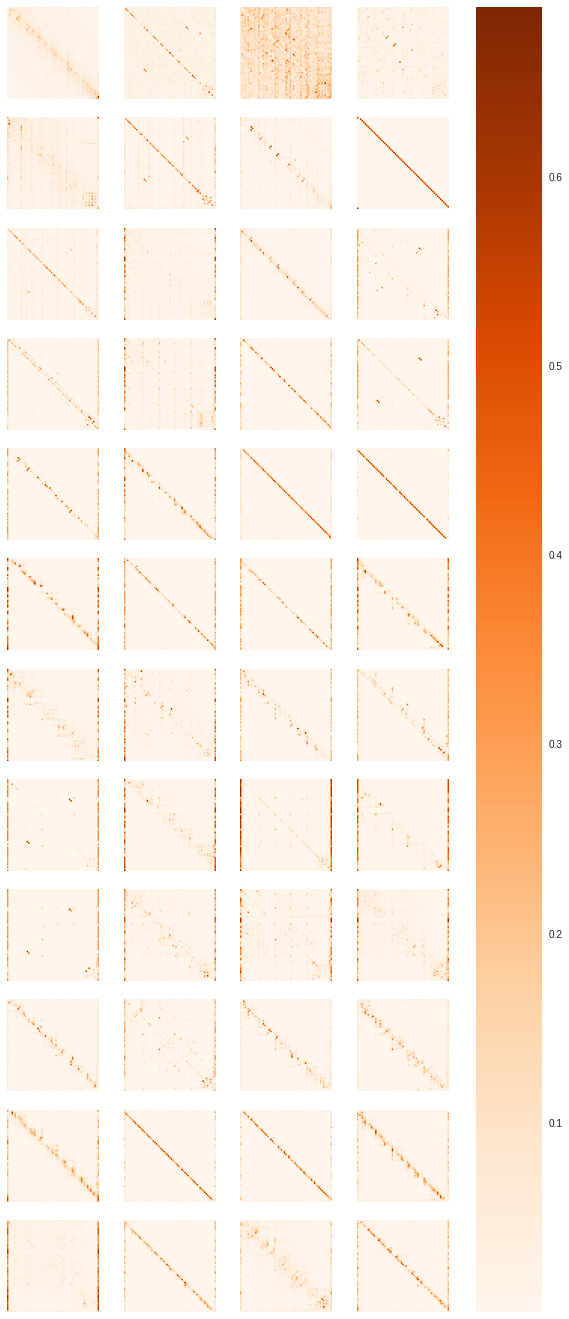

In [ ]:
fig = visualize_all(rand_output_base, crop_len)#, title="Attention map for {}: base model".format(task))
fig.savefig('base_token_attention.png')
files.download('base_token_attention.png')